In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import sem
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import cortex as cx
import seaborn as sns
from scipy.stats import ttest_rel, ttest_ind
from sklearn.linear_model import LinearRegression
from prf_expect.utils import io
from prf_expect.utils.fit import PRFModel, Parameters, fwhmax_fwatmin
from prf_expect.utils.beh import calculate_visual_angle
from prf_expect.utils.viz import desaturate_palette, sample_cmap, cm_to_inch
from matplotlib.colors import LightSource
from scipy.stats import t
from matplotlib import rc
from matplotlib import font_manager

In [2]:
glm_analysis_type = "TRMI-type1"
save_npy = True
save_figs = True
comb_ROIs = False

In [3]:
cwd = os.getcwd()
font_dirs = [Path(cwd).parent.parent / "arial"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

rc("pdf", fonttype=42, use14corefonts=False)
rc("axes", linewidth=0.5)
rc("font", **{"family": "Arial"})
rc("text", usetex=False)
rc("xtick", labelsize=6)
rc("ytick", labelsize=6)
rc("axes", labelsize=7)
rc("legend", fontsize=6)

plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.minor.size"] = 1

# set up figure parameters
markeredgecolor = ".4"
bar_linewidth = 0.5
bar_alpha = 0.7
xticks_rotation = 45
marker = "s"
marker_edge_width = 0.5
markersize = 3 / 2.54
errorbar_linewidth = 0.5
errorbar_capsize = 2 / 2.54
errorbar_capthick = 0.5

In [4]:
settings = io.load_settings()

Loading settings from /Users/dionysus/Library/CloudStorage/OneDrive-Personal/Workbench/pRF_expect_pub/pRF_expect_analysis/prf_expect/settings.yml


In [5]:
subjects = settings["general"]["subject_list"]
dummy_scans = settings["mri"]["dummy_scans"]
space = settings["mri"]["space"]
project_dir = os.path.join(settings["general"]["data_dir"], "data")
runs = ["01", "02", "03"]
half_vis_angle = (
    calculate_visual_angle(
        settings["monitor"]["screen_size_cm"][1],
        settings["monitor"]["screen_distance_cm"],
    )
    / 2
)
r2_thre = 0.1
print(f"Half visual angle: {half_vis_angle}")

Half visual angle: 5.723617240476087


In [6]:
# set half_vis_angle to a smaller value to avoid edge effects
half_vis_angle = 5

In [7]:
ROIs_list_long = (
    "V1",
    "V2",
    "V3",
    "V3A",
    "V3B",
    "V4",
    "LO1",
    "LO2",
    "VO1",
    "VO2",
    "hMT",
    "MST",
    "IPS0",
    "IPS1",
    "IPS2",
    "IPS3",
    "IPS4",
    "IPS5",
)
ROIs_list_short = ["V1", "V2", "V3", "V3AB", "hV4", "LO", "TO", "VO", "IPS"]
roi_verts = cx.get_roi_verts("fsaverage", ROIs_list_long)
V1 = roi_verts["V1"]
vis_verts = np.array([], dtype=int)
for roi in roi_verts:
    vis_verts = np.concatenate((vis_verts, roi_verts[roi]))

In [8]:
# norm subject number to [0,1]
def norm_subjects(subj):
    subj = np.array(subj)
    return (subj - min(subj)) / (max(subj) - min(subj))


norm_subID = norm_subjects(list(range(0, len(subjects) + 1)))

In [9]:
combined_roi_verts = {}
combined_roi_verts["V1"] = roi_verts["V1"]
combined_roi_verts["V2"] = roi_verts["V2"]
combined_roi_verts["V3"] = roi_verts["V3"]
combined_roi_verts["V3AB"] = np.concatenate((roi_verts["V3A"], roi_verts["V3B"]))
combined_roi_verts["hV4"] = roi_verts["V4"]
combined_roi_verts["LO"] = np.concatenate((roi_verts["LO1"], roi_verts["LO2"]))
combined_roi_verts["TO"] = np.concatenate((roi_verts["hMT"], roi_verts["MST"]))
combined_roi_verts["VO"] = np.concatenate((roi_verts["VO1"], roi_verts["VO2"]))
combined_roi_verts["IPS"] = np.concatenate(
    (
        roi_verts["IPS0"],
        roi_verts["IPS1"],
        roi_verts["IPS2"],
        roi_verts["IPS3"],
        roi_verts["IPS4"],
        roi_verts["IPS5"],
    )
)
if comb_ROIs == True:
    rois = combined_roi_verts
else:
    rois = roi_verts

ROIs_list = list(rois.keys())

In [10]:
# Define paths and data exp parameters
data_dir = Path(settings["general"]["data_dir"], "data")
tasks = settings["design"]["tasks"]
space = settings["mri"]["space"]

## Load pRF results

In [11]:
# calculate IQR
def iqr(data):
    return np.nanpercentile(data, 75) - np.nanpercentile(data, 25)

In [12]:
rsq_list = []
rsq_list_2 = []
b_list = []
d_list = []
x_list = []
y_list = []
pa_list = []
ecc_list = []
prf_size_list = []
prf_hwhm_list = []
size_ratio_list = []
TRMI_list = []
viol_beta_spardm_list = []
viol_beta_omitdm_list = []
rsq_nanmask_list = []
viol_tstat_list = []

for subject in subjects:
    tsv_name = Path.joinpath(
        data_dir,
        "derivatives",
        "prf_data",
        subject,
        "ses-1",
        "prf_fits",
        "prf_params",
        f"{subject}_ses-1_final-fit_space-{space}_model-norm_stage-iter_desc-prf_params.tsv",
    )
    TRMI_npy_name = Path.joinpath(
        data_dir,
        "derivatives",
        "prf_data",
        subject,
        "ses-1",
        glm_analysis_type,
        f"{subject}_ses-1_space-{space}_surprise-TRMI.npy",
    )
    viol_rsq = Path.joinpath(
        data_dir,
        "derivatives",
        "prf_data",
        subject,
        "ses-1",
        glm_analysis_type,
        f"{subject}_ses-1_space-{space}_surprise-viol_rsq.npy",
    )
    viol_beta_spardm = Path.joinpath(
        data_dir,
        "derivatives",
        "prf_data",
        subject,
        "ses-1",
        glm_analysis_type,
        f"{subject}_ses-1_space-{space}_surprise-viol_beta_sparsedm.npy",
    )
    viol_beta_omitdm = Path.joinpath(
        data_dir,
        "derivatives",
        "prf_data",
        subject,
        "ses-1",
        glm_analysis_type,
        f"{subject}_ses-1_space-{space}_surprise-viol_beta_omitdm.npy",
    )
    viol_tstat_npy_name = Path.joinpath(
        data_dir,
        "derivatives",
        "prf_data",
        subject,
        "ses-1",
        glm_analysis_type,
        f"{subject}_ses-1_space-{space}_surprise-viol_t_contrast.npy",
    )
    data = pd.read_csv(
        tsv_name,
        sep="\t",
        header=0,
    )
    mask = data["r2"] >= r2_thre
    mask_broadcasted = np.tile(mask, (data.shape[1], 1)).T
    params = data.where(mask_broadcasted)
    params_np = params.to_numpy()
    b = params["B"]
    d = params["D"]
    verts_nr = params["r2"].shape[0]

    sub_vis_rsq = np.zeros(verts_nr)
    sub_vis_rsq[:] = np.nan
    sub_vis_rsq = params["r2"]

    sub_vis_x = np.zeros(verts_nr)
    sub_vis_x[:] = np.nan
    sub_vis_x = params["x"]

    sub_vis_y = np.zeros(verts_nr)
    sub_vis_y[:] = np.nan
    sub_vis_y = params["y"]

    sub_vis_pa = np.zeros(verts_nr)
    sub_vis_pa[:] = np.nan
    sub_vis_pa = params["polar"]

    sub_vis_ecc = np.zeros(verts_nr)
    sub_vis_ecc[:] = np.nan
    sub_vis_ecc = params["ecc"]

    sub_vis_prf_ampl = np.zeros(verts_nr)
    sub_vis_prf_ampl[:] = np.nan
    sub_vis_prf_ampl = params["prf_ampl"]

    sub_vis_prf_size = np.zeros(verts_nr)
    sub_vis_prf_size[:] = np.nan
    sub_vis_prf_size = params["prf_size"]

    sub_vis_prf_hwhm = np.zeros(verts_nr)
    sub_vis_prf_hwhm[:] = np.nan
    sub_vis_prf_hwhm, _ = fwhmax_fwatmin("norm", params_np, normalize_RFs=False)

    sub_vis_size_ratio = np.zeros(verts_nr)
    sub_vis_size_ratio[:] = np.nan
    sub_vis_size_ratio = params["size ratio"]

    sub_vis_TRMI = np.load(TRMI_npy_name)
    sub_vis_viol_rsq = np.load(viol_rsq)
    sub_vis_viol_tstat = np.load(viol_tstat_npy_name)

    sub_vis_viol_beta_sparsedm = np.load(viol_beta_spardm)
    sub_vis_viol_beta_omitdm = np.load(viol_beta_omitdm)

    sub_vis_rsq[sub_vis_ecc > half_vis_angle] = np.nan
    sub_vis_rsq[sub_vis_prf_ampl < 0.0] = np.nan
    sub_vis_rsq[sub_vis_rsq < 0.0] = np.nan

    sub_vis_rsq_2 = sub_vis_rsq.copy()
    sub_vis_rsq_2[sub_vis_viol_rsq < 0.0] = np.nan

    sub_vis_b = np.nan_to_num(b.values, copy=True, nan=0.0)
    sub_vis_d = np.nan_to_num(d.values, copy=True, nan=0.0)
    sub_vis_x = np.nan_to_num(sub_vis_x, copy=True, nan=0.0)
    sub_vis_y = np.nan_to_num(sub_vis_y, copy=True, nan=0.0)
    sub_vis_pa = np.nan_to_num(sub_vis_pa, copy=True, nan=0.0)
    sub_vis_prf_size = np.nan_to_num(sub_vis_prf_size, copy=True, nan=0.0)
    sub_vis_prf_hwhm = np.nan_to_num(sub_vis_prf_hwhm, copy=True, nan=0.0)
    sub_vis_size_ratio = np.nan_to_num(sub_vis_size_ratio, copy=True, nan=0.0)
    sub_vis_ecc = np.nan_to_num(sub_vis_ecc, copy=True, nan=0.0)

    iqr_TRMI = iqr(sub_vis_TRMI)
    sub_vis_TRMI[sub_vis_ecc > half_vis_angle] = 0
    sub_vis_TRMI[sub_vis_prf_ampl < 0.0] = 0
    sub_vis_TRMI[sub_vis_rsq < 0.0] = 0
    sub_vis_TRMI_masked = sub_vis_TRMI.copy()
    sub_vis_TRMI_masked[sub_vis_TRMI > (np.nanmedian(sub_vis_TRMI) + 2 * iqr_TRMI)] = 0
    sub_vis_TRMI_masked[sub_vis_TRMI < (np.nanmedian(sub_vis_TRMI) - 2 * iqr_TRMI)] = 0
    sub_vis_TRMI_masked = np.nan_to_num(sub_vis_TRMI_masked, copy=True, nan=0.0)
    viz_data_rsq_nanmask = ~np.isnan(sub_vis_rsq)

    iqr_vis_viol_tstat = iqr(sub_vis_viol_tstat)
    sub_vis_viol_tstat[
        sub_vis_viol_tstat > (np.nanmedian(sub_vis_viol_tstat) + 2 * iqr_vis_viol_tstat)
    ] = 0
    sub_vis_viol_tstat[sub_vis_ecc > half_vis_angle] = 0
    sub_vis_viol_tstat[sub_vis_prf_ampl < 0.0] = 0
    sub_vis_viol_tstat[sub_vis_rsq < 0.0] = 0
    sub_vis_viol_tstat_masked = sub_vis_viol_tstat.copy()
    sub_vis_viol_tstat_masked[
        sub_vis_viol_tstat > (np.nanmedian(sub_vis_viol_tstat) + 2 * iqr_vis_viol_tstat)
    ] = 0
    sub_vis_viol_tstat_masked[
        sub_vis_viol_tstat < (np.nanmedian(sub_vis_viol_tstat) - 2 * iqr_vis_viol_tstat)
    ] = 0
    sub_vis_viol_tstat_masked = np.nan_to_num(
        sub_vis_viol_tstat_masked, copy=True, nan=0.0
    )

    rsq_list.append(sub_vis_rsq)
    rsq_list_2.append(sub_vis_rsq_2)
    b_list.append(sub_vis_b)
    d_list.append(sub_vis_d)
    x_list.append(sub_vis_x)
    y_list.append(sub_vis_y)
    pa_list.append(sub_vis_pa)
    ecc_list.append(sub_vis_ecc)
    prf_size_list.append(sub_vis_prf_size)
    prf_hwhm_list.append(sub_vis_prf_hwhm)
    size_ratio_list.append(sub_vis_size_ratio)

    TRMI_list.append(sub_vis_TRMI_masked)
    rsq_nanmask_list.append(viz_data_rsq_nanmask)
    viol_tstat_list.append(sub_vis_viol_tstat_masked)
    viol_beta_spardm_list.append(sub_vis_viol_beta_sparsedm)
    viol_beta_omitdm_list.append(sub_vis_viol_beta_omitdm)

rsq_list = np.array(rsq_list)
rsq_list_2 = np.array(rsq_list_2)
rsq_nanmask_list = np.array(rsq_nanmask_list)

avg_nanmask = np.any(rsq_nanmask_list, axis=0)
avg_rsq = np.nanmean(rsq_list, axis=0)
avg_rsq = np.nan_to_num(avg_rsq, copy=True, nan=0.0)
avg_rsq_2 = np.nanmean(rsq_list_2, axis=0)
avg_rsq_2 = np.nan_to_num(avg_rsq_2, copy=True, nan=0.0)
rsq_list_nonan = np.nan_to_num(rsq_list, copy=True, nan=1e-6)
rsq_list_2_nonan = np.nan_to_num(rsq_list_2, copy=True, nan=1e-6)

b_list = np.array(b_list)
avg_b = np.average(b_list, axis=0, weights=rsq_list_nonan)

d_list = np.array(d_list)
avg_d = np.average(d_list, axis=0, weights=rsq_list_nonan)

x_list = np.array(x_list)
avg_x = np.average(x_list, axis=0, weights=rsq_list_nonan)

y_list = np.array(y_list)
avg_y = np.average(y_list, axis=0, weights=rsq_list_nonan)

# calculate polar angle with x and y
avg_pa = np.arctan2(avg_y, avg_x)

pa_list = np.array(pa_list)

ecc_list = np.array(ecc_list)
avg_ecc = np.average(ecc_list, axis=0, weights=rsq_list_nonan)

prf_size_list = np.array(prf_size_list)
avg_prf_size = np.average(prf_size_list, axis=0, weights=rsq_list_nonan)

prf_hwhm_list = np.array(prf_hwhm_list)
avg_prf_hwhm = np.average(prf_hwhm_list, axis=0, weights=rsq_list_nonan)

size_ratio_list = np.array(size_ratio_list)
avg_size_ratio = np.average(size_ratio_list, axis=0, weights=rsq_list_nonan)

TRMI_list = np.array(TRMI_list)
avg_TRMI = np.average(TRMI_list, axis=0, weights=rsq_list_2_nonan)

viol_tstat_list = np.array(viol_tstat_list)
viol_tstat_list = np.nan_to_num(viol_tstat_list, copy=True, nan=0.0)
avg_viol_tstat = np.average(viol_tstat_list, axis=0, weights=rsq_list_2_nonan)

viol_beta_spardm_list = np.array(viol_beta_spardm_list)
viol_beta_spardm_list = np.nan_to_num(viol_beta_spardm_list, copy=True, nan=0.0)
avg_viol_beta_spardm = np.average(viol_beta_spardm_list, axis=0, weights=rsq_list_nonan)

viol_beta_omitdm_list = np.array(viol_beta_omitdm_list)
viol_beta_omitdm_list = np.nan_to_num(viol_beta_omitdm_list, copy=True, nan=0.0)
avg_viol_beta_omitdm = np.average(viol_beta_omitdm_list, axis=0, weights=rsq_list_nonan)


avg_b[~avg_nanmask] = np.nan
avg_d[~avg_nanmask] = np.nan
avg_ecc[~avg_nanmask] = np.nan
avg_TRMI[~avg_nanmask] = np.nan
avg_viol_tstat[~avg_nanmask] = np.nan

/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_69379/1645424012.py:198: RuntimeWarning: Mean of empty slice
  avg_rsq = np.nanmean(rsq_list, axis=0)
/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_69379/1645424012.py:200: RuntimeWarning: Mean of empty slice
  avg_rsq_2 = np.nanmean(rsq_list_2, axis=0)


## Save results to local

In [13]:
analysis_result_dir = Path(cwd).parent / "data"

avg_rsq_path = analysis_result_dir.joinpath(
    "group_analysis-pRF_space-fsaverage_rsq.npy"
)
avg_polar_angle_path = analysis_result_dir.joinpath(
    "group_analysis-pRF_space-fsaverage_pa.npy"
)
avg_ecc_path = analysis_result_dir.joinpath(
    "group_analysis-pRF_space-fsaverage_ecc.npy"
)
avg_b_path = analysis_result_dir.joinpath("group_analysis-pRF_space-fsaverage_b.npy")
avg_d_path = analysis_result_dir.joinpath("group_analysis-pRF_space-fsaverage_d.npy")
avg_prf_size_path = analysis_result_dir.joinpath(
    "group_analysis-pRF_space-fsaverage_prf_size.npy"
)
avg_TRMI_path = analysis_result_dir.joinpath(
    f"group_analysis-{glm_analysis_type}_space-fsaverage_TRMI.npy"
)
avg_viol_tstat_path = analysis_result_dir.joinpath(
    f"group_analysis-{glm_analysis_type}_space-fsaverage_viol_tstat.npy"
)
if save_npy:
    np.save(avg_rsq_path, avg_rsq)
    np.save(avg_polar_angle_path, avg_pa)
    np.save(avg_ecc_path, avg_ecc)
    np.save(avg_b_path, avg_b)
    np.save(avg_d_path, avg_d)
    np.save(avg_prf_size_path, avg_prf_size)
    np.save(avg_TRMI_path, avg_TRMI)
    np.save(avg_viol_tstat_path, avg_viol_tstat)

In [14]:
figure_result_dir = Path(cwd).parent / "figures"

In [15]:
group_rois_param = pd.DataFrame()

for i, subject in enumerate(subjects):
    viz_data_rsq_nanmask = ~np.isnan(rsq_list[i, :])
    viz_data_rsq_2_nanmask = ~np.isnan(rsq_list_2[i, :])
    for param_name, param in zip(
        ["B", "D", "prf_size", "ecc", "TRMI", "viol_tstat"],
        [b_list, d_list, prf_size_list, ecc_list, TRMI_list, viol_tstat_list],
    ):
        sub_rois_param = {}
        sub_vis_param = param[i, :]
        for roi in rois:
            roi_vers = rois[roi]
            if param_name == "TRMI":
                roi_nanmask = viz_data_rsq_2_nanmask[roi_vers]
            else:
                roi_nanmask = viz_data_rsq_nanmask[roi_vers]
            sub_rois_param[roi] = [
                np.average(
                    sub_vis_param[roi_vers][roi_nanmask],
                    weights=avg_rsq[roi_vers][roi_nanmask],
                ),
                sem(sub_vis_param[roi_vers][roi_nanmask]),
            ]
        # convert to pandas
        df_sub_rois_param = pd.DataFrame(sub_rois_param).transpose().reset_index()
        df_sub_rois_param.columns = ["ROIs", "values", "SEM"]
        # add columns with subject name
        df_sub_rois_param["subjects"] = subject
        df_sub_rois_param["param"] = param_name
        group_rois_param = pd.concat([group_rois_param, df_sub_rois_param], axis=0)

df_group_rois_param = group_rois_param[
    ["subjects", "param", "ROIs", "values", "SEM"]
].reset_index(drop=True)

In [16]:
sub_vis_param = b_list[0, :]
roi_vers = rois["V1"]
roi_nanmask = viz_data_rsq_nanmask[roi_vers]
sub_vis_param[roi_vers][roi_nanmask]
print(
    np.std(sub_vis_param[roi_vers][roi_nanmask])
    / np.sqrt(sub_vis_param[roi_vers][roi_nanmask].size)
)

3.9452920828548805


In [17]:
np.std(sub_vis_param[roi_vers][roi_nanmask]) / np.sqrt(
    sub_vis_param[roi_vers][roi_nanmask].size
)

np.float64(3.9452920828548805)

In [18]:
# trans list to df
viz_param = pd.DataFrame()
for param_name, param in zip(
    ["B", "D", "prf_size", "TRMI"], [b_list, d_list, prf_size_list, TRMI_list]
):
    for i, subject in enumerate(subjects):
        viz_data_rsq_nanmask = ~np.isnan(rsq_list[i, :])
        viz_data_rsq_2_nanmask = ~np.isnan(rsq_list_2[i, :])
        sub_vis_param = param[i, :]

        for roi in rois:
            roi_vers = rois[roi]
            if param_name == "TRMI":
                roi_nanmask = viz_data_rsq_2_nanmask[roi_vers]
            else:
                roi_nanmask = viz_data_rsq_nanmask[roi_vers]
            sub_rois_param = sub_vis_param[roi_vers][roi_nanmask]
            # convert to pandas
            df_sub_rois_param = pd.DataFrame(sub_rois_param)
            df_sub_rois_param.columns = ["values"]
            # add columns with subject name
            df_sub_rois_param["subjects"] = subject
            df_sub_rois_param["param"] = param_name
            df_sub_rois_param["ROIs"] = roi
            viz_param = pd.concat([viz_param, df_sub_rois_param], axis=0)

## Better bar plots

In [19]:
original_gist_rainbow = plt.cm.gist_rainbow  # Original colormap
palette_desaturated_gist_rainbow = desaturate_palette(
    original_gist_rainbow, saturation=1
)

In [20]:
gist_rainbow_desaturated = desaturate_palette(
    plt.colormaps.get_cmap("gist_rainbow"), saturation=0.80, lightness=0.9
)
gist_rainbow_sampled = sample_cmap(gist_rainbow_desaturated, len(ROIs_list))

gist_rainbow_desaturated_2 = desaturate_palette(
    plt.colormaps.get_cmap("gist_rainbow"), saturation=1
)
gist_rainbow_sampled_2 = sample_cmap(gist_rainbow_desaturated_2, len(ROIs_list))

gist_rainbow_desaturated_3 = desaturate_palette(
    plt.colormaps.get_cmap("gist_rainbow"), saturation=1.0, lightness=0.6
)
gist_rainbow_sampled_3 = sample_cmap(gist_rainbow_desaturated_3, len(ROIs_list))

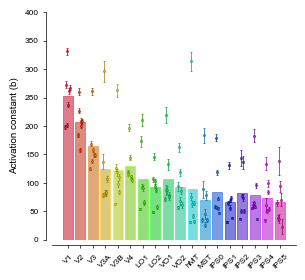

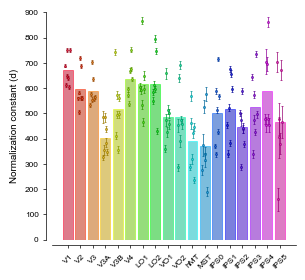

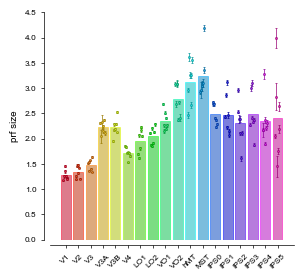

In [21]:
# B values
# assign the x variable to the hue
group_B = (
    df_group_rois_param[df_group_rois_param.param == "B"]["values"]
    .groupby(df_group_rois_param["ROIs"])
    .mean()
)
group_B = group_B.reindex(ROIs_list)

fig, ax = plt.subplots(figsize=cm_to_inch(8, 7.5))
ax = sns.barplot(
    data=df_group_rois_param[df_group_rois_param.param == "B"],
    x="ROIs",
    y="values",
    errorbar=None,
    palette=gist_rainbow_sampled,
    hue="ROIs",
)
# Changing the color of error bars to match bar color or a custom color

# change bar edge color
for i, bar in enumerate(ax.patches):
    bar.set_edgecolor(gist_rainbow_sampled_2[i])
    bar.set_linewidth(bar_linewidth)
    bar.set_alpha(bar_alpha)

sns.despine(offset=4)
plt.xticks(rotation=xticks_rotation)
plt.xlabel("")
plt.ylabel("Activation constant (b)")
plt.legend([], [], frameon=False)
patches = ax.patches
lines_per_err = 3
for i, line in enumerate(ax.get_lines()):
    newcolor = patches[i // lines_per_err].get_facecolor()
    line.set_color(newcolor)

for bar, line in zip(ax.patches, ax.get_lines()[::1]):
    line.set_color([0.0, 0.0, 0.0])
    line.set_alpha(1)

for iroi, roi in enumerate(ROIs_list):
    for isubject, subject in enumerate(subjects):
        pos = ROIs_list.index(roi) + (norm_subID[isubject] - 0.5) * 0.4
        mean_data = df_group_rois_param[
            (df_group_rois_param.param == "B")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["values"].values[0]
        sem_data = df_group_rois_param[
            (df_group_rois_param.param == "B")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["SEM"].values[0]
        ax.errorbar(
            pos,
            mean_data,
            yerr=sem_data,
            fmt="none",
            ecolor=gist_rainbow_sampled_3[iroi],
            elinewidth=errorbar_linewidth,
            capsize=errorbar_capsize,
            capthick=errorbar_capthick,
        )
        ax.plot(
            pos,
            mean_data,
            marker=marker,
            markeredgecolor=gist_rainbow_sampled_3[iroi],
            markerfacecolor=gist_rainbow_sampled[iroi],
            markeredgewidth=marker_edge_width,
            markersize=markersize,
        )

# remove spine
ax.set_ylim(0, 400)
plt.show()
B_barplot_fn = figure_result_dir.joinpath(
    "group_analysis-pRF_space-fsaverage_B_barplot.pdf"
)
if save_figs:
    ax.figure.savefig(B_barplot_fn, bbox_inches="tight", dpi=600)


# D values
group_D = (
    df_group_rois_param[df_group_rois_param.param == "D"]["values"]
    .groupby(df_group_rois_param["ROIs"])
    .mean()
)
group_D = group_D.reindex(ROIs_list)

fig, ax = plt.subplots(figsize=cm_to_inch(8, 7.5))
ax = sns.barplot(
    data=df_group_rois_param[df_group_rois_param.param == "D"],
    x="ROIs",
    y="values",
    errorbar=None,
    palette=gist_rainbow_sampled,
    hue="ROIs",
)

for i, bar in enumerate(ax.patches):
    bar.set_edgecolor(gist_rainbow_sampled_2[i])
    bar.set_linewidth(bar_linewidth)
    bar.set_alpha(bar_alpha)

sns.despine(offset=4)
plt.xticks(rotation=xticks_rotation)
plt.xlabel("")
plt.ylabel("Normalization constant (d)")
plt.legend([], [], frameon=False)

patches = ax.patches
lines_per_err = 3
for i, line in enumerate(ax.get_lines()):
    newcolor = patches[i // lines_per_err].get_facecolor()
    line.set_color(newcolor)

for bar, line in zip(ax.patches, ax.get_lines()[::1]):
    line.set_color([0.0, 0.0, 0.0])
    line.set_alpha(1)  # Ensures the error bars are fully opaque

for iroi, roi in enumerate(ROIs_list):
    for isubject, subject in enumerate(subjects):
        pos = ROIs_list.index(roi) + (norm_subID[isubject] - 0.5) * 0.4
        mean_data = df_group_rois_param[
            (df_group_rois_param.param == "D")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["values"].values[0]
        sem_data = df_group_rois_param[
            (df_group_rois_param.param == "D")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["SEM"].values[0]
        ax.errorbar(
            pos,
            mean_data,
            yerr=sem_data,
            fmt="none",
            ecolor=gist_rainbow_sampled_3[iroi],
            elinewidth=errorbar_linewidth,
            capsize=errorbar_capsize,
            capthick=errorbar_capthick,
        )
        ax.plot(
            pos,
            mean_data,
            marker=marker,
            markeredgecolor=gist_rainbow_sampled_3[iroi],
            markerfacecolor=gist_rainbow_sampled[iroi],
            markeredgewidth=marker_edge_width,
            markersize=markersize,
        )

ax.set_ylim(0, 900)
plt.show()
if save_figs:
    ax.figure.savefig(
        figure_result_dir.joinpath("group_analysis-pRF_space-fsaverage_D_barplot.pdf"),
        bbox_inches="tight",
        dpi=600,
    )


# pRF size values
group_prf_size = (
    df_group_rois_param[df_group_rois_param.param == "prf_size"]["values"]
    .groupby(df_group_rois_param["ROIs"])
    .mean()
)
group_prf_size = group_prf_size.reindex(ROIs_list)

fig, ax = plt.subplots(figsize=cm_to_inch(8, 7.5))
ax = sns.barplot(
    data=df_group_rois_param[df_group_rois_param.param == "prf_size"],
    x="ROIs",
    y="values",
    errorbar=None,
    palette=gist_rainbow_sampled,
    hue="ROIs",
)

for i, bar in enumerate(ax.patches):
    bar.set_edgecolor(gist_rainbow_sampled_2[i])
    bar.set_linewidth(bar_linewidth)
    bar.set_alpha(bar_alpha)

sns.despine(offset=4)
plt.xticks(rotation=xticks_rotation)
plt.xlabel("")
plt.ylabel("prf size")
plt.legend([], [], frameon=False)

patches = ax.patches
lines_per_err = 3
for i, line in enumerate(ax.get_lines()):
    newcolor = patches[i // lines_per_err].get_facecolor()
    line.set_color(newcolor)

for bar, line in zip(ax.patches, ax.get_lines()[::1]):
    line.set_color([0.0, 0.0, 0.0])
    line.set_alpha(1)  # Ensures the error bars are fully opaque

for iroi, roi in enumerate(ROIs_list):
    for isubject, subject in enumerate(subjects):
        pos = ROIs_list.index(roi) + (norm_subID[isubject] - 0.5) * 0.4
        mean_data = df_group_rois_param[
            (df_group_rois_param.param == "prf_size")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["values"].values[0]
        sem_data = df_group_rois_param[
            (df_group_rois_param.param == "prf_size")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["SEM"].values[0]
        ax.errorbar(
            pos,
            mean_data,
            yerr=sem_data,
            fmt="none",
            ecolor=gist_rainbow_sampled_3[iroi],
            elinewidth=errorbar_linewidth,
            capsize=errorbar_capsize,
            capthick=errorbar_capthick,
        )
        ax.plot(
            pos,
            mean_data,
            marker=marker,
            markeredgecolor=gist_rainbow_sampled_3[iroi],
            markerfacecolor=gist_rainbow_sampled[iroi],
            markeredgewidth=marker_edge_width,
            markersize=markersize,
        )

ax.set_ylim(0, 4.5)
plt.show()
if save_figs:
    ax.figure.savefig(
        figure_result_dir.joinpath(
            "group_analysis-pRF_space-fsaverage_prf_size_barplot.pdf"
        ),
        bbox_inches="tight",
        dpi=600,
    )

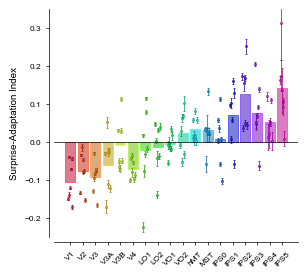

In [22]:
fig, ax = plt.subplots(figsize=cm_to_inch(8, 7.5))
sns.barplot(
    data=df_group_rois_param[df_group_rois_param.param == "TRMI"],
    x="ROIs",
    y="values",
    errorbar=None,
    hue="ROIs",
    palette=gist_rainbow_sampled,
    ax=ax,
)

# change bar edge color
for i, bar in enumerate(ax.patches):
    bar.set_edgecolor(gist_rainbow_sampled_2[i])
    bar.set_linewidth(bar_linewidth)
    bar.set_alpha(bar_alpha)

# sns.stripplot(data=df_group_rois_param[df_group_rois_param.param=="TRMI"],
#               x="ROIs",
#               y="values",
#               color=".7",
#               size=2,)

for iroi, roi in enumerate(ROIs_list):
    for isubject, subject in enumerate(subjects):
        pos = ROIs_list.index(roi) + (norm_subID[isubject] - 0.5) * 0.4
        mean_data = df_group_rois_param[
            (df_group_rois_param.param == "TRMI")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["values"].values[0]
        sem_data = df_group_rois_param[
            (df_group_rois_param.param == "TRMI")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["SEM"].values[0]
        ax.errorbar(
            pos,
            mean_data,
            yerr=sem_data,
            fmt="none",
            elinewidth=errorbar_linewidth,
            ecolor=gist_rainbow_sampled_3[iroi],
            capsize=errorbar_capsize,
            capthick=errorbar_capthick,
            # clip_on=False,
        )
        ax.plot(
            pos,
            mean_data,
            marker=marker,
            markeredgecolor=gist_rainbow_sampled_3[iroi],
            markerfacecolor=gist_rainbow_sampled[iroi],
            markeredgewidth=marker_edge_width,
            markersize=markersize,
            clip_on=False,
        )

sns.despine(offset=4)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Surprise-Adaptation Index")
plt.ylim(-0.25, 0.35)
# plt.ylim(-0.25, 0.55)
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])
plt.legend([], [], frameon=False)
plt.axhline(0, color="black", linewidth=0.5)
plt.show()
if save_figs:
    ax.figure.savefig(
        figure_result_dir.joinpath(
            f"group_analysis-{glm_analysis_type}_space-fsaverage_TRMI_barplot.pdf"
        ),
        bbox_inches="tight",
        dpi=600,
    )

In [23]:
pivot_table = (
    df_group_rois_param.groupby(["ROIs", "param"])
    .agg({"values": ["mean"]})["values"]["mean"]
    .unstack()
)

In [24]:
# change the order of the ROIs
pivot_table = pivot_table.reindex(ROIs_list)

## Anova

In [25]:
# Anova
from statsmodels.stats.anova import AnovaRM

# TRMI
df_group_rois_param_viol = df_group_rois_param[df_group_rois_param.param == "TRMI"]
aovrm = AnovaRM(df_group_rois_param_viol, "values", "subjects", within=["ROIs"])
res = aovrm.fit()
print(res)

               Anova
     F Value  Num DF  Den DF  Pr > F
------------------------------------
ROIs  9.5294 17.0000 102.0000 0.0000



## correlation between B and TRMI (vertex level)

In [26]:
# correlation between B and TRMI
vis_mask = np.full(avg_b.shape, False)
vis_mask[vis_verts] = True
correlation, pvalue = stats.spearmanr(
    avg_b[vis_mask], avg_TRMI[vis_mask], nan_policy="omit"
)
print(
    f"correlation between B and TRMI: {correlation:.2f}, p-value: {pvalue:.2f} (vertex level, spearman's r)"
)

# correlation between D and TRMI
correlation, pvalue = stats.spearmanr(
    avg_d[vis_mask], avg_TRMI[vis_mask], nan_policy="omit"
)
print(
    f"correlation between D and TRMI: {correlation:.2f}, p-value: {pvalue:.2f} (vertex level, spearman's r)"
)

# correlation between prf_size and TRMI
correlation, pvalue = stats.spearmanr(
    avg_prf_size[vis_mask], avg_TRMI[vis_mask], nan_policy="omit"
)
print(
    f"correlation between prf_size and TRMI: {correlation:.2f}, p-value: {pvalue:.2f} (vertex level, spearman's r)"
)

# correlation between B and prf_size
correlation, pvalue = stats.spearmanr(
    avg_b[vis_mask], avg_prf_size[vis_mask], nan_policy="omit"
)
print(
    f"correlation between B and prf_size: {correlation:.2f}, p-value: {pvalue:.2f} (vertex level, spearman's r)"
)

correlation between B and TRMI: -0.38, p-value: 0.00 (vertex level, spearman's r)
correlation between D and TRMI: -0.18, p-value: 0.00 (vertex level, spearman's r)
correlation between prf_size and TRMI: 0.43, p-value: 0.00 (vertex level, spearman's r)
correlation between B and prf_size: -0.53, p-value: 0.00 (vertex level, spearman's r)


In [27]:
prf_size = avg_prf_size[vis_verts]
prf_size = prf_size - np.nanmean(prf_size)
prf_size = prf_size / np.nanstd(prf_size)
# remove nan
prf_size_nanidx = np.isnan(prf_size)
prf_size = prf_size.reshape(-1, 1)

b = avg_b[vis_verts]
b = b - np.nanmean(b)
b = b / np.nanstd(b)
b_nanidx = np.isnan(b)
b = b.reshape(-1, 1)

TRMI = avg_TRMI[vis_verts]
TRMI = TRMI - np.nanmean(TRMI)
TRMI = TRMI / np.nanstd(TRMI)
TRMI_nanidx = np.isnan(TRMI)
TRMI = TRMI.reshape(-1, 1)

# if there is nan in either prf_size, b, or TRMI, remove the vertex
nanidx = np.logical_or(prf_size_nanidx, b_nanidx, TRMI_nanidx)
prf_size = prf_size[~nanidx]
b = b[~nanidx]
TRMI = TRMI[~nanidx]

reg = LinearRegression().fit(prf_size, b)
b_res = b - reg.predict(prf_size)
b_res = b_res.reshape(-1)

reg = LinearRegression().fit(prf_size, TRMI)
TRMI_res = TRMI - reg.predict(prf_size)
correlation, pvalue = stats.spearmanr(b_res, TRMI_res, nan_policy="omit")
print(
    f"correlation between B and prf_size: {correlation:.2f}, p-value: {pvalue:.2f} (vertex level, spearman's r)"
)

correlation between B and prf_size: -0.26, p-value: 0.00 (vertex level, spearman's r)


## Correlation between B and TRMI (region level)

In [28]:
# correlation between B and TRMI
correlation, pvalue = stats.spearmanr(pivot_table.B.values, pivot_table.TRMI.values)
print(
    f"correlation between B and TRMI: {correlation:.2f}, p-value: {pvalue:.2f} (region level, spearman's r)"
)

# correlation between D and TRMI
correlation, pvalue = stats.spearmanr(pivot_table.D.values, pivot_table.TRMI.values)
print(
    f"correlation between D and TRMI: {correlation:.2f}, p-value: {pvalue:.2f} (region level, spearman's r)"
)

# correlation between prf_size and TRMI
correlation, pvalue = stats.spearmanr(
    pivot_table.prf_size.values, pivot_table.TRMI.values
)
print(
    f"correlation between prf_size and TRMI: {correlation:.2f}, p-value: {pvalue:.2f} (region level, spearman's r)"
)

# correlation between B and prf_size
correlation, pvalue = stats.spearmanr(pivot_table.B.values, pivot_table.prf_size.values)
print(
    f"correlation between B and prf_size: {correlation:.2f}, p-value: {pvalue:.2f} (region level, spearman's r)"
)

# regress out prf size from parameter B
# regress out prf size from TRMI
b = pivot_table.B.values
d = pivot_table.D.values
TRMI = pivot_table.TRMI.values
prf_size = pivot_table.prf_size.values

prf_size = prf_size - np.nanmean(prf_size)
b = b - np.nanmean(b)
d = d - np.nanmean(d)
TRMI = TRMI - np.nanmean(TRMI)
prf_size = prf_size / np.nanstd(prf_size)
b = b / np.nanstd(b)
d = d / np.nanstd(d)
TRMI = TRMI / np.nanstd(TRMI)
prf_size = np.nan_to_num(prf_size, copy=True, nan=0.0)
b = np.nan_to_num(b, copy=True, nan=0.0)
d = np.nan_to_num(d, copy=True, nan=0.0)
TRMI = np.nan_to_num(TRMI, copy=True, nan=0.0)

prf_size = prf_size.reshape(-1, 1)
b = b.reshape(-1, 1)
d = d.reshape(-1, 1)
TRMI = TRMI.reshape(-1, 1)

# here we only regress out prf size from B on region level

reg = LinearRegression().fit(prf_size, b)
b_res = b - reg.predict(prf_size)
b_res = b_res.reshape(-1)

reg = LinearRegression().fit(prf_size, TRMI)
TRMI_res = TRMI - reg.predict(prf_size)
TRMI_res = TRMI_res.reshape(-1)

correlation, pvalue = stats.spearmanr(b_res, TRMI_res)
print(
    f"correlation between B_res and TRMI_res after regressing out prf size: {correlation:.2f}, p-value: {pvalue:.2f} (region level, spearman's r)"
)

# here we only regress out prf size from B on region level

reg = LinearRegression().fit(prf_size, d)
d_res = d - reg.predict(prf_size)
d_res = d_res.reshape(-1)

reg = LinearRegression().fit(prf_size, TRMI)
TRMI_res = TRMI - reg.predict(prf_size)
TRMI_res = TRMI_res.reshape(-1)

correlation, pvalue = stats.spearmanr(d_res, TRMI_res)
print(
    f"correlation between D_res and TRMI_res after regressing out prf size: {correlation:.2f}, p-value: {pvalue:.2f} (region level, spearman's r)"
)

correlation between B and TRMI: -0.92, p-value: 0.00 (region level, spearman's r)
correlation between D and TRMI: -0.59, p-value: 0.01 (region level, spearman's r)
correlation between prf_size and TRMI: 0.75, p-value: 0.00 (region level, spearman's r)
correlation between B and prf_size: -0.76, p-value: 0.00 (region level, spearman's r)
correlation between B_res and TRMI_res after regressing out prf size: -0.71, p-value: 0.00 (region level, spearman's r)
correlation between D_res and TRMI_res after regressing out prf size: 0.23, p-value: 0.35 (region level, spearman's r)


### 3D scatter plot pilot

In [29]:
def plot_3D_sphere(ax, radius, x, y, z, color="b", zorder=2, lightsource=None):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    u = np.linspace(0, 2 * np.pi, 32)  # Azimuthal angle
    v = np.linspace(0, np.pi, 32)  # Polar angle
    # Generate the coordinates for the sphere and zoom the radius according to the xlim, ylim, and zlim
    x = radius * np.outer(np.cos(u), np.sin(v)) * (xlim[1] - xlim[0]) / 100 + x
    y = radius * np.outer(np.sin(u), np.sin(v)) * (ylim[1] - ylim[0]) / 100 + y
    z = (
        radius * np.outer(np.ones(np.size(u)), np.cos(v)) * (zlim[1] - zlim[0]) / 100
        + z
    )

    # Use a color map to simulate material
    ax.plot_surface(
        x,
        y,
        z,
        # rstride=1,
        # cstride=1,
        color=color,
        linewidth=0,
        antialiased=True,
        alpha=0.9,
        shade=True,
        zorder=zorder,
        lightsource=lightsource,
    )

    # Enhance lighting with shading (pseudo-lighting)
    ax.plot_surface(
        x, y, z, color="white", alpha=0.25, linewidth=0, antialiased=True, zorder=zorder
    )

    # Set the aspect ratio to be equal, so the sphere looks correct
    ax.set_box_aspect([1, 1, 1])

    return ax

In [30]:
def plot_2D_square_on_3D_x(ax, x, y, z, height, color="b"):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    height /= (zlim[1] - zlim[0]) / 200

    width = height * (ylim[1] - ylim[0]) / (zlim[1] - zlim[0])
    # Assume the square is parallel to the y-z plane
    y_plane = np.array([y - width / 2, y + width / 2])
    z_plane = np.array([z - height / 2, z + height / 2])
    y_plane, z_plane = np.meshgrid(y_plane, z_plane)
    x_plane = np.zeros(y_plane.shape) + x
    ax.plot_surface(
        x_plane,
        y_plane,
        z_plane,
        alpha=0.9,
        color=color,
        shade=False,
        linewidth=0,
        antialiased=True,
        zorder=2,
    )

    return ax

In [31]:
def plot_2D_square_on_3D_y(ax, x, y, z, height, color="b"):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    height /= (zlim[1] - zlim[0]) / 200

    width = height * (xlim[1] - xlim[0]) / (zlim[1] - zlim[0])
    # Assume the square is parallel to the x-z plane
    x_plane = np.array([x - width / 2, x + width / 2])
    z_plane = np.array([z - height / 2, z + height / 2])
    x_plane, z_plane = np.meshgrid(x_plane, z_plane)
    y_plane = np.zeros(x_plane.shape) + y
    ax.plot_surface(
        x_plane,
        y_plane,
        z_plane,
        alpha=0.9,
        color=color,
        shade=False,
        linewidth=0,
        antialiased=True,
        zorder=2,
    )

    return ax

In [32]:
def plot_2D_square_on_3D_z(ax, x, y, z, height, color="b"):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()

    correct_factor = height / (zlim[1] - zlim[0]) * 200
    height = correct_factor * (xlim[1] - xlim[0]) / (zlim[1] - zlim[0])
    width = correct_factor * (ylim[1] - ylim[0]) / (zlim[1] - zlim[0])
    # Assume the square is parallel to the x-y plane
    x_plane = np.array([x - height / 2, x + height / 2])
    y_plane = np.array([y - width / 2, y + width / 2])
    x_plane, y_plane = np.meshgrid(x_plane, y_plane)
    z_plane = np.zeros(x_plane.shape) + z

    ax.plot_surface(
        x_plane,
        y_plane,
        z_plane,
        alpha=0.9,
        color=color,
        shade=False,
        linewidth=0,
        antialiased=True,
        zorder=1,
    )

    return ax

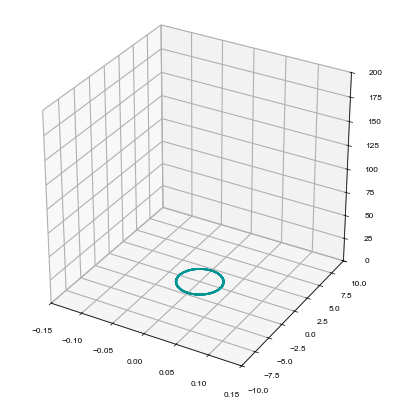

In [33]:
def plot_2D_annulus_on_3D_z(ax, x, y, z, radius, a, color="b"):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    radius /= (xlim[1] - xlim[0]) * 1000
    a /= (xlim[1] - xlim[0]) * 1000

    theta = np.linspace(0, 2.0 * np.pi, 32)
    phi = np.linspace(0, 2 * np.pi, 32)
    theta, phi = np.meshgrid(theta, phi)
    # radius, a = 10, 0.2
    x = (radius + a * np.cos(theta)) * np.cos(phi) + x
    y = (radius + a * np.cos(theta)) * np.sin(phi) / (
        (xlim[1] - xlim[0]) / (ylim[1] - ylim[0])
    ) + y
    z = a * np.sin(theta) + z

    ax.plot_surface(
        x,
        y,
        z,
        rstride=5,
        cstride=5,
        color=color,
        edgecolors=color,
        zorder=1,
        alpha=0.8,
        shade=True,
        antialiased=True,
    )
    ax.set_box_aspect([1, 1, 1])
    return ax


# Example usage
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim(-0.15, 0.15)
ax.set_ylim(-10, 10)
ax.set_zlim(0, 200)
plot_2D_annulus_on_3D_z(ax, x=0, y=0, z=0, radius=10, a=0.2, color="c")
plt.show()

### 3D scatter plot version 1 (best version)

/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_69379/3156336884.py:155: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


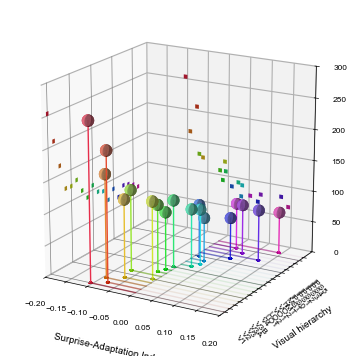

In [34]:
dist_from_0 = 1
dist_from_end = 1

fig = plt.figure(figsize=cm_to_inch(11, 11))
ax = fig.add_subplot(projection="3d", computed_zorder=False)
ax.view_init(azim=300, elev=18)

ax.set_xlabel("Surprise-Adaptation Index")
ax.set_xlim(-0.20, 0.20)

ax.set_ylabel("Visual hierarchy")
ax.set_ylim(0, len(ROIs_list) + dist_from_0 + dist_from_end)

ax.set_yticks(
    range(dist_from_0, int((dist_from_0 + len(ROIs_list))), 1),
)
yticklabels = [
    *ROIs_list,
]
ax.set_yticklabels(yticklabels, rotation=-45)

ax.set_zticks(range(0, 350, 50))
ax.set_zlim(0, 300)
ax.set_zlabel("Activation constant (b)")

x = pivot_table.TRMI.values
y = np.array(range(dist_from_0, len(ROIs_list) + dist_from_0))
z = pivot_table.B.values

for iroi, roi in enumerate(ROIs_list):
    ax = plot_2D_square_on_3D_y(
        ax,
        x[iroi],
        ax.get_ylim()[1],
        z[iroi],
        10,
        color=gist_rainbow_sampled_3[iroi],
    )
    ax = plot_2D_square_on_3D_x(
        ax,
        ax.get_xlim()[0],
        y[iroi],
        z[iroi],
        10,
        color=gist_rainbow_sampled_3[iroi],
    )
    ax = plot_2D_annulus_on_3D_z(
        ax,
        x[iroi],
        y[iroi],
        ax.get_zlim()[0],
        1,
        0.02,
        color=gist_rainbow_sampled_2[iroi],
    )

# plot 3D sphere and lines
for iroi, roi in enumerate(ROIs_list):
    # plot_3D_sphere along the opposite direction of visual hierarchy
    iroi = len(ROIs_list) - iroi - 1
    ax.plot(
        [x[iroi], x[iroi]],
        [y[iroi], y[iroi]],
        [0, z[iroi]],
        color=gist_rainbow_sampled[iroi],
        linewidth=1,
        zorder=2,
    )
    light_azdeg = (160 - ax.azim) % 360
    light_altdeg = ax.elev
    ax = plot_3D_sphere(
        ax,
        3,
        x[iroi],
        y[iroi],
        z[iroi],
        color=gist_rainbow_sampled_2[iroi],
        lightsource=LightSource(azdeg=light_azdeg, altdeg=light_altdeg),
    )

# Add a face at where TRMI=0
# Define the coordinates of the plane
y_plane = np.array(ax.get_ylim())
z_plane = np.array(ax.get_zlim())
y_plane, z_plane = np.meshgrid(y_plane, z_plane)
x_plane = np.zeros(y_plane.shape)
# ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.13, color="red")

sns.despine()

ax.yaxis._axinfo["grid"]["linewidth"] = 0  # Set grid line width to zero

# Get the x and z limits of the plot
xmin, xmax = ax.get_xlim()
zmin, zmax = ax.get_zlim()

# Retrieve major tick positions
major_yticks = range(
    dist_from_0, int((len(ROIs_list) + dist_from_0 + dist_from_end)), 4
)
# Draw grid lines at major tick positions
for ytick in major_yticks:
    # Grid line along Y-axis at the bottom of Z-axis
    ax.plot(
        [xmin, xmax],
        [ytick, ytick],
        [zmin, zmin],
        color="gray",
        linestyle="-",
        linewidth=0.5,
        zorder=1,
    )
    # Grid line along Z-axis at the minimum Y-axis value
    ax.plot(
        [xmin, xmin],
        [ytick, ytick],
        [zmin, zmax],
        color="gray",
        linestyle="-",
        linewidth=0.5,
        zorder=1,
    )

for iroi, roi in enumerate(ROIs_list):
    ax.plot(
        [x[iroi], 0],
        [y[iroi], y[iroi]],
        [zmin, zmin],
        color=gist_rainbow_sampled_3[iroi],
        linewidth=1,
        zorder=2,
        alpha=0.5,
    )
    if x[iroi] < 0:
        ax.plot(
            [x[iroi], ax.get_xlim()[1]],
            [y[iroi], y[iroi]],
            [zmin, zmin],
            color=gist_rainbow_sampled_3[iroi],
            linewidth=1,
            zorder=2,
            alpha=0.1,
        )
    else:
        ax.plot(
            [0, ax.get_xlim()[1]],
            [y[iroi], y[iroi]],
            [zmin, zmin],
            color=gist_rainbow_sampled_3[iroi],
            linewidth=1,
            zorder=2,
            alpha=0.05,
        )

plt.tight_layout()
plt.show()
if save_figs:
    ax.figure.savefig(
        figure_result_dir.joinpath(
            f"group_analysis-{glm_analysis_type}_space-fsaverage_B_TRMI_scatter.pdf"
        ),
        bbox_inches="tight",
        dpi=600,
    )

## B, TRMI, and visual hierarchy, without pRF size

In [35]:
# remove vertex which is nan in viz_data_rsq_2_nanmask from variable rois
rois_nan2mask = {roi: rois[roi][viz_data_rsq_2_nanmask[rois[roi]]] for roi in rois}

In [36]:
group_rois_param_noprf_size = pd.DataFrame()

for i, subject in enumerate(subjects):
    viz_data_rsq_nanmask = ~np.isnan(rsq_list[i, :])
    viz_data_rsq_2_nanmask = ~np.isnan(rsq_list_2[i, :])
    prf_size = prf_size_list[i, :]
    # prf_size = prf_size[viz_data_rsq_2_nanmask]
    prf_size = prf_size - np.nanmean(prf_size)
    prf_size = prf_size / np.nanstd(prf_size)
    prf_size = prf_size.reshape(-1, 1)
    for param_name, param in zip(["B", "D", "TRMI"], [b_list, d_list, TRMI_list]):
        # for param_name, param in zip(["B",], [b_list,]):
        sub_rois_param = {}
        sub_vis_param = param[i, :]
        reg = LinearRegression().fit(prf_size, sub_vis_param)
        sub_vis_param_res = sub_vis_param - reg.predict(prf_size)
        sub_vis_param_res = sub_vis_param_res.reshape(-1)

        for roi in rois:
            roi_vers = rois_nan2mask[roi]
            roi_nanmask = viz_data_rsq_2_nanmask[roi_vers]
            # regress out prf size from sub_vis_param
            sub_rois_param[roi] = [
                np.average(sub_vis_param_res[roi_vers], weights=avg_rsq[roi_vers]),
                sem(sub_vis_param_res[roi_vers]),
            ]
        # convert to pandas
        df_sub_rois_param = pd.DataFrame(sub_rois_param).transpose().reset_index()
        df_sub_rois_param.columns = ["ROIs", "values", "SEM"]
        # add columns with subject name
        df_sub_rois_param["subjects"] = subject
        df_sub_rois_param["param"] = param_name
        group_rois_param_noprf_size = pd.concat(
            [group_rois_param_noprf_size, df_sub_rois_param], axis=0
        )

group_rois_param_noprf_size = group_rois_param_noprf_size[
    ["subjects", "param", "ROIs", "values", "SEM"]
].reset_index(drop=True)

pivot_table_noprf_size = (
    group_rois_param_noprf_size.groupby(["ROIs", "param"])
    .agg({"values": ["mean"]})["values"]["mean"]
    .unstack()
)
pivot_table_noprf_size = pivot_table_noprf_size.reindex(ROIs_list)

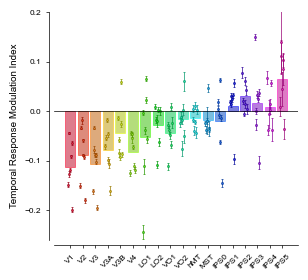

In [37]:
fig, ax = plt.subplots(figsize=cm_to_inch(8, 7.5))
sns.barplot(
    data=group_rois_param_noprf_size[group_rois_param_noprf_size.param == "TRMI"],
    x="ROIs",
    y="values",
    errorbar=None,
    hue="ROIs",
    palette=gist_rainbow_sampled,
    ax=ax,
)

# change bar edge color
for i, bar in enumerate(ax.patches):
    bar.set_edgecolor(gist_rainbow_sampled_2[i])
    bar.set_linewidth(bar_linewidth)
    bar.set_alpha(bar_alpha)

# sns.stripplot(data=group_rois_param_noprf_size[group_rois_param_noprf_size.param=="TRMI"],
#               x="ROIs",
#               y="values",
#               color=".7",
#               size=2,)

for iroi, roi in enumerate(ROIs_list):
    for isubject, subject in enumerate(subjects):
        pos = ROIs_list.index(roi) + (norm_subID[isubject] - 0.5) * 0.4
        mean_data = group_rois_param_noprf_size[
            (group_rois_param_noprf_size.param == "TRMI")
            & (group_rois_param_noprf_size.ROIs == roi)
            & (group_rois_param_noprf_size.subjects == subject)
        ]["values"].values[0]
        sem_data = group_rois_param_noprf_size[
            (group_rois_param_noprf_size.param == "TRMI")
            & (group_rois_param_noprf_size.ROIs == roi)
            & (group_rois_param_noprf_size.subjects == subject)
        ]["SEM"].values[0]
        ax.errorbar(
            pos,
            mean_data,
            yerr=sem_data,
            fmt="none",
            elinewidth=errorbar_linewidth,
            ecolor=gist_rainbow_sampled_3[iroi],
            capsize=errorbar_capsize,
            capthick=errorbar_capthick,
            # clip_on=False,
        )
        ax.plot(
            pos,
            mean_data,
            marker=marker,
            markeredgecolor=gist_rainbow_sampled_3[iroi],
            markerfacecolor=gist_rainbow_sampled[iroi],
            markeredgewidth=marker_edge_width,
            markersize=markersize,
            clip_on=False,
        )

sns.despine(offset=4)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Temporal Response Modulation Index") 
plt.ylim(-0.26, 0.2)
# plt.ylim(-0.25, 0.35)
plt.yticks([-0.2, -0.1, 0, 0.1, 0.2])
plt.legend([], [], frameon=False)
plt.axhline(0, color="black", linewidth=0.5)
plt.show()
if save_figs:
    ax.figure.savefig(
        figure_result_dir.joinpath(
            f"group_analysis-{glm_analysis_type}_space-fsaverage_TRMI_noprfszie_barplot.pdf"
        ),
        bbox_inches="tight",
        dpi=600,
    )

/var/folders/1x/nhszthp519l9hrq_yddm9yhr0000gn/T/ipykernel_69379/401189115.py:156: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


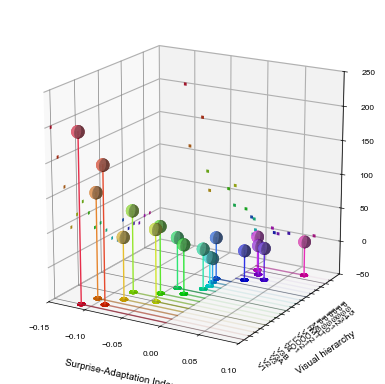

In [38]:
dist_from_0 = 1
dist_from_end = 1
# x is TRMI, y is ROIs, z is B

fig = plt.figure(figsize=cm_to_inch(12, 12))
ax = fig.add_subplot(projection="3d", computed_zorder=False)
ax.view_init(azim=300, elev=18)

ax.set_xlabel("Surprise-Adaptation Index")
ax.set_xlim(-0.15, 0.10)

ax.set_ylabel("Visual hierarchy")
ax.set_ylim(0, len(ROIs_list) + dist_from_0 + dist_from_end)

ax.set_yticks(
    range(dist_from_0, int((dist_from_0 + len(ROIs_list))), 1),
)
yticklabels = [
    *ROIs_list,
]
ax.set_yticklabels(yticklabels, rotation=-45)

ax.set_zticks(range(-50, 300, 50))
ax.set_zlim(-50, 250)
ax.set_zlabel("Activation constant (b)")

x = pivot_table_noprf_size.TRMI.values
y = np.array(range(dist_from_0, len(ROIs_list) + dist_from_0))
z = pivot_table_noprf_size.B.values

for iroi, roi in enumerate(ROIs_list):
    ax = plot_2D_square_on_3D_y(
        ax,
        x[iroi],
        ax.get_ylim()[1],
        z[iroi],
        7,
        color=gist_rainbow_sampled_3[iroi],
    )
    ax = plot_2D_square_on_3D_x(
        ax,
        ax.get_xlim()[0],
        y[iroi],
        z[iroi],
        7,
        color=gist_rainbow_sampled_3[iroi],
    )
    ax = plot_2D_annulus_on_3D_z(
        ax,
        x[iroi],
        y[iroi],
        ax.get_zlim()[0],
        1,
        0.02,
        color=gist_rainbow_sampled_2[iroi],
    )

# plot 3D sphere and lines
for iroi, roi in enumerate(ROIs_list):
    # plot_3D_sphere along the opposite direction of visual hierarchy
    iroi = len(ROIs_list) - iroi - 1
    ax.plot(
        [x[iroi], x[iroi]],
        [y[iroi], y[iroi]],
        [-50, z[iroi]],
        color=gist_rainbow_sampled[iroi],
        linewidth=1,
        zorder=2,
    )
    light_azdeg = (160 - ax.azim) % 360
    light_altdeg = ax.elev
    ax = plot_3D_sphere(
        ax,
        3,
        x[iroi],
        y[iroi],
        z[iroi],
        color=gist_rainbow_sampled_2[iroi],
        lightsource=LightSource(azdeg=light_azdeg, altdeg=light_altdeg),
    )

# Add a face at where TRMI=0
# Define the coordinates of the plane
y_plane = np.array(ax.get_ylim())
z_plane = np.array(ax.get_zlim())
y_plane, z_plane = np.meshgrid(y_plane, z_plane)
x_plane = np.zeros(y_plane.shape)
# ax.plot_surface(x_plane, y_plane, z_plane, alpha=0.13, color="red")

sns.despine()

ax.yaxis._axinfo["grid"]["linewidth"] = 0  # Set grid line width to zero

# Get the x and z limits of the plot
xmin, xmax = ax.get_xlim()
zmin, zmax = ax.get_zlim()

# Retrieve major tick positions
major_yticks = range(
    dist_from_0, int((len(ROIs_list) + dist_from_0 + dist_from_end)), 4
)
# Draw grid lines at major tick positions
for ytick in major_yticks:
    # Grid line along Y-axis at the bottom of Z-axis
    ax.plot(
        [xmin, xmax],
        [ytick, ytick],
        [zmin, zmin],
        color="gray",
        linestyle="-",
        linewidth=0.5,
        zorder=1,
    )
    # Grid line along Z-axis at the minimum Y-axis value
    ax.plot(
        [xmin, xmin],
        [ytick, ytick],
        [zmin, zmax],
        color="gray",
        linestyle="-",
        linewidth=0.5,
        zorder=1,
    )

for iroi, roi in enumerate(ROIs_list):
    ax.plot(
        [x[iroi], 0],
        [y[iroi], y[iroi]],
        [zmin, zmin],
        color=gist_rainbow_sampled_3[iroi],
        linewidth=1,
        zorder=2,
        alpha=0.5,
    )
    if x[iroi] < 0:
        ax.plot(
            [x[iroi], ax.get_xlim()[1]],
            [y[iroi], y[iroi]],
            [zmin, zmin],
            color=gist_rainbow_sampled_3[iroi],
            linewidth=1,
            zorder=2,
            alpha=0.1,
        )
    else:
        ax.plot(
            [0, ax.get_xlim()[1]],
            [y[iroi], y[iroi]],
            [zmin, zmin],
            color=gist_rainbow_sampled_3[iroi],
            linewidth=1,
            zorder=2,
            alpha=0.05,
        )

plt.tight_layout()
plt.show()
if save_figs:
    ax.figure.savefig(
        figure_result_dir.joinpath(
            f"group_analysis-{glm_analysis_type}_space-fsaverage_B_TRMI_noprfszie_scatter.pdf"
        ),
        bbox_inches="tight",
        dpi=600,
    )

In [39]:
correlation, pvalue = stats.pearsonr(
    pivot_table_noprf_size.B.values, pivot_table_noprf_size.TRMI.values
)
print(
    f"correlation between B and TRMI: {correlation:.2f}, p-value: {pvalue:.2f} (region level, pearson's r)"
)

correlation between B and TRMI: -0.82, p-value: 0.00 (region level, pearson's r)


## t-test bar chart for TRMI

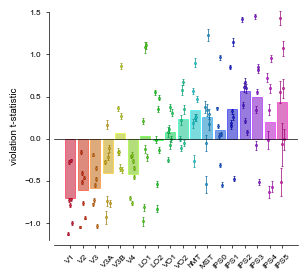

In [40]:
fig, ax = plt.subplots(figsize=cm_to_inch(8, 7.5))
sns.barplot(
    data=df_group_rois_param[df_group_rois_param.param == "viol_tstat"],
    x="ROIs",
    y="values",
    errorbar=None,
    hue="ROIs",
    palette=gist_rainbow_sampled,
    ax=ax,
)

# change bar edge color
for i, bar in enumerate(ax.patches):
    bar.set_edgecolor(gist_rainbow_sampled_2[i])
    bar.set_linewidth(bar_linewidth)
    bar.set_alpha(bar_alpha)

for iroi, roi in enumerate(ROIs_list):
    for isubject, subject in enumerate(subjects):
        pos = ROIs_list.index(roi) + (norm_subID[isubject] - 0.5) * 0.4
        mean_data = df_group_rois_param[
            (df_group_rois_param.param == "viol_tstat")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["values"].values[0]
        sem_data = df_group_rois_param[
            (df_group_rois_param.param == "viol_tstat")
            & (df_group_rois_param.ROIs == roi)
            & (df_group_rois_param.subjects == subject)
        ]["SEM"].values[0]
        ax.errorbar(
            pos,
            mean_data,
            yerr=sem_data,
            fmt="none",
            elinewidth=errorbar_linewidth,
            ecolor=gist_rainbow_sampled_3[iroi],
            capsize=errorbar_capsize,
            capthick=errorbar_capthick,
            clip_on=False,
        )
        ax.plot(
            pos,
            mean_data,
            marker=marker,
            markeredgecolor=gist_rainbow_sampled_3[iroi],
            markerfacecolor=gist_rainbow_sampled[iroi],
            markeredgewidth=marker_edge_width,
            markersize=markersize,
            clip_on=False,
        )

sns.despine(offset=4)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("violation t-statistic")
plt.ylim(-1.2, 1.5)
# plt.yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])
plt.legend([], [], frameon=False)

plt.axhline(0, color="black", linewidth=0.5)
plt.show()
if save_figs:
    ax.figure.savefig(
        figure_result_dir.joinpath(
            f"group_analysis-{glm_analysis_type}_space-fsaverage_viol_tstat_barplot.pdf"
        ),
        bbox_inches="tight",
        dpi=600,
    )

# Correlation between prf_size and ecc

In [41]:
for i, r in enumerate(combined_roi_verts.keys()):
    print(r, i)
print("+++")
for i, r in enumerate(rois.keys()):
    print(r, i)

V1 0
V2 1
V3 2
V3AB 3
hV4 4
LO 5
TO 6
VO 7
IPS 8
+++
V1 0
V2 1
V3 2
V3A 3
V3B 4
V4 5
LO1 6
LO2 7
VO1 8
VO2 9
hMT 10
MST 11
IPS0 12
IPS1 13
IPS2 14
IPS3 15
IPS4 16
IPS5 17


In [42]:
def reg_plot(
    ax, x, y, color, edgecolors, label, marker="o", xbin_arange=(1, 5, 1), markersize=20
):
    sns.regplot(
        x=x,
        y=y,
        scatter=True,
        order=1,
        truncate=True,
        color=color,
        line_kws={"linewidth": 0.5},
        scatter_kws={
            "clip_on": False,
            "s": 100,
            "edgecolor": edgecolors,
            "linewidth": 0.5,
            "s": markersize,
        },
        x_bins=np.arange(*xbin_arange),
        ax=ax,
        label=label,
        marker=marker,
    )
    return ax

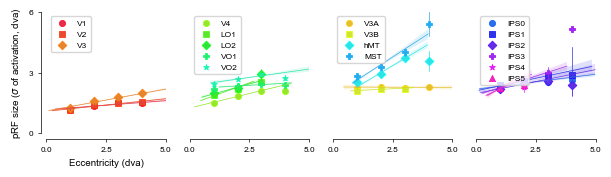

In [43]:
fig, ax = plt.subplots(1, 4, figsize=cm_to_inch(18, 4))

# early visual areas
for roi, color, edgecolors, marker_roi in zip(
    ["V1", "V2", "V3"],
    [gist_rainbow_sampled[0], gist_rainbow_sampled[1], gist_rainbow_sampled[2]],
    [gist_rainbow_sampled_2[0], gist_rainbow_sampled_2[1], gist_rainbow_sampled_2[2]],
    ["o", "s", "D"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_prf_size = avg_prf_size[rois[roi]]
    ax[0] = reg_plot(
        ax[0], roi_ecc, roi_prf_size, color, edgecolors, roi, marker=marker_roi
    )
    ax[0].legend(loc="upper left")
    ax[0].set_xlim(0, 5)
    ax[0].set_ylim(0, 6)
    ax[0].set_xticks([0, 2.5, 5])
    ax[0].set_yticks([0, 3, 6])
    ax[0].set_ylabel(r"pRF size ($\sigma$ of activation, dva)")
    ax[0].set_xlabel("Eccentricity (dva)")

# ventral stream
for roi, color, edgecolors, marker_roi in zip(
    ["V4", "LO1", "LO2", "VO1", "VO2"],
    [
        gist_rainbow_sampled[5],
        gist_rainbow_sampled[6],
        gist_rainbow_sampled[7],
        gist_rainbow_sampled[8],
        gist_rainbow_sampled[9],
    ],
    [
        gist_rainbow_sampled_2[5],
        gist_rainbow_sampled_2[6],
        gist_rainbow_sampled_2[7],
        gist_rainbow_sampled_2[8],
        gist_rainbow_sampled_2[9],
    ],
    ["o", "s", "D", "P", "*"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_prf_size = avg_prf_size[rois[roi]]
    ax[1] = reg_plot(
        ax[1], roi_ecc, roi_prf_size, color, edgecolors, roi, marker=marker_roi
    )
    ax[1].legend(loc="upper left")
    ax[1].set_xlim(0, 5)
    ax[1].set_ylim(0, 6)
    ax[1].set_xticks([0, 2.5, 5])
    ax[1].set_yticks([])

# dorsal stream (V3AB and TO)
for roi, color, edgecolors, marker_roi in zip(
    ["V3A", "V3B", "hMT", "MST"],
    [
        gist_rainbow_sampled[3],
        gist_rainbow_sampled[4],
        gist_rainbow_sampled[10],
        gist_rainbow_sampled[11],
    ],
    [
        gist_rainbow_sampled_2[3],
        gist_rainbow_sampled_2[4],
        gist_rainbow_sampled_2[10],
        gist_rainbow_sampled_2[11],
    ],
    ["o", "s", "D", "P"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_prf_size = avg_prf_size[rois[roi]]
    ax[2] = reg_plot(
        ax[2], roi_ecc, roi_prf_size, color, edgecolors, roi, marker=marker_roi
    )
    ax[2].legend(loc="upper left")
    ax[2].set_xlim(0, 5)
    ax[2].set_ylim(0, 6)
    ax[2].set_xticks([0, 2.5, 5])
    ax[2].set_yticks([])

# dorsal stream (IPS)
for roi, color, edgecolors, marker_roi in zip(
    ["IPS0", "IPS1", "IPS2", "IPS3", "IPS4", "IPS5"],
    [
        gist_rainbow_sampled[12],
        gist_rainbow_sampled[13],
        gist_rainbow_sampled[14],
        gist_rainbow_sampled[15],
        gist_rainbow_sampled[16],
        gist_rainbow_sampled[17],
    ],
    [
        gist_rainbow_sampled_2[12],
        gist_rainbow_sampled_2[13],
        gist_rainbow_sampled_2[14],
        gist_rainbow_sampled_2[15],
        gist_rainbow_sampled_2[16],
        gist_rainbow_sampled_2[17],
    ],
    ["o", "s", "D", "P", "*", "^"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_prf_size = avg_prf_size[rois[roi]]
    ax[3] = reg_plot(
        ax[3], roi_ecc, roi_prf_size, color, edgecolors, roi, marker=marker_roi
    )
    ax[3].legend(loc="upper left")
    ax[3].set_xlim(0, 5)
    ax[3].set_ylim(0, 6)
    ax[3].set_xticks([0, 2.5, 5])
    ax[3].set_yticks([])

for axi in ax:
    for line in axi.get_lines():
        line.set_linewidth(0.5)

sns.despine(offset=4)
ax[1].spines["left"].set_visible(False)
ax[2].spines["left"].set_visible(False)
ax[3].spines["left"].set_visible(False)

plt.show()
corr_prfsize_ecc_scatter_fn = figure_result_dir.joinpath(
    "group_analysis-pRF_space-fsaverage_corr_prfsize_ecc_scatter.pdf"
)

if save_figs:
    fig.savefig(corr_prfsize_ecc_scatter_fn, bbox_inches="tight", dpi=600)

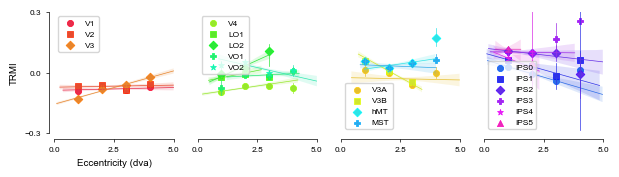

In [44]:
fig, ax = plt.subplots(1, 4, figsize=cm_to_inch(18, 4))
ylim = (-0.3, 0.3)
# early visual areas
for roi, color, edgecolors, marker_roi in zip(
    ["V1", "V2", "V3"],
    [gist_rainbow_sampled[0], gist_rainbow_sampled[1], gist_rainbow_sampled[2]],
    [gist_rainbow_sampled_2[0], gist_rainbow_sampled_2[1], gist_rainbow_sampled_2[2]],
    ["o", "s", "D"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[0] = reg_plot(
        ax[0], roi_ecc, roi_TRMI, color, edgecolors, roi, marker=marker_roi
    )
    ax[0].legend(loc="upper left")
    ax[0].set_xlim(0, 5)
    ax[0].set_xticks([0, 2.5, 5])
    ax[0].set_ylim(ylim[0], ylim[1])
    ax[0].set_yticks([ylim[0], 0, ylim[1]])
    ax[0].set_ylabel("TRMI")
    ax[0].set_xlabel("Eccentricity (dva)")

# ventral stream
for roi, color, edgecolors, marker_roi in zip(
    ["V4", "LO1", "LO2", "VO1", "VO2"],
    [
        gist_rainbow_sampled[5],
        gist_rainbow_sampled[6],
        gist_rainbow_sampled[7],
        gist_rainbow_sampled[8],
        gist_rainbow_sampled[9],
    ],
    [
        gist_rainbow_sampled_2[5],
        gist_rainbow_sampled_2[6],
        gist_rainbow_sampled_2[7],
        gist_rainbow_sampled_2[8],
        gist_rainbow_sampled_2[9],
    ],
    ["o", "s", "D", "P", "*"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[1] = reg_plot(
        ax[1], roi_ecc, roi_TRMI, color, edgecolors, roi, marker=marker_roi
    )
    ax[1].legend(loc="upper left")
    ax[1].set_xlim(0, 5)
    ax[1].set_xticks([0, 2.5, 5])
    ax[1].set_ylim(ylim[0], ylim[1])
    ax[1].set_yticks([])

# dorsal stream (V3AB and TO)
for roi, color, edgecolors, marker_roi in zip(
    ["V3A", "V3B", "hMT", "MST"],
    [
        gist_rainbow_sampled[3],
        gist_rainbow_sampled[4],
        gist_rainbow_sampled[10],
        gist_rainbow_sampled[11],
    ],
    [
        gist_rainbow_sampled_2[3],
        gist_rainbow_sampled_2[4],
        gist_rainbow_sampled_2[10],
        gist_rainbow_sampled_2[11],
    ],
    ["o", "s", "D", "P"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[2] = reg_plot(
        ax[2], roi_ecc, roi_TRMI, color, edgecolors, roi, marker=marker_roi
    )
    ax[2].legend(loc="lower left")
    ax[2].set_xlim(0, 5)
    ax[2].set_xticks([0, 2.5, 5])
    ax[2].set_ylim(ylim[0], ylim[1])
    ax[2].set_yticks([])

# dorsal stream (IPS)
for roi, color, edgecolors, marker_roi in zip(
    ["IPS0", "IPS1", "IPS2", "IPS3", "IPS4", "IPS5"],
    [
        gist_rainbow_sampled[12],
        gist_rainbow_sampled[13],
        gist_rainbow_sampled[14],
        gist_rainbow_sampled[15],
        gist_rainbow_sampled[16],
        gist_rainbow_sampled[17],
    ],
    [
        gist_rainbow_sampled_2[12],
        gist_rainbow_sampled_2[13],
        gist_rainbow_sampled_2[14],
        gist_rainbow_sampled_2[15],
        gist_rainbow_sampled_2[16],
        gist_rainbow_sampled_2[17],
    ],
    ["o", "s", "D", "P", "*", "^"],
):
    roi_ecc = avg_ecc[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[3] = reg_plot(
        ax[3], roi_ecc, roi_TRMI, color, edgecolors, roi, marker=marker_roi
    )
    ax[3].legend(loc="lower left")
    ax[3].set_xlim(0, 5)
    ax[3].set_xticks([0, 2.5, 5])
    ax[3].set_ylim(ylim[0], ylim[1])
    ax[3].set_yticks([])

for axi in ax:
    for line in axi.get_lines():
        line.set_linewidth(0.5)
sns.despine(offset=4)
ax[1].spines["left"].set_visible(False)
ax[2].spines["left"].set_visible(False)
ax[3].spines["left"].set_visible(False)
plt.show()
corr_TRMI_ecc_scatter_fn = figure_result_dir.joinpath(
    f"group_analysis-{glm_analysis_type}_space-fsaverage_corr_TRMI_ecc_scatter.pdf"
)


if save_figs:
    fig.savefig(corr_TRMI_ecc_scatter_fn, bbox_inches="tight", dpi=600)

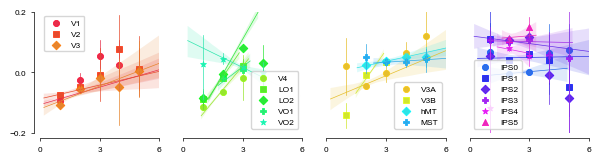

In [45]:
fig, ax = plt.subplots(1, 4, figsize=cm_to_inch(18, 4))
ylim = (-0.2, 0.2)
# early visual areas
for roi, color, edgecolors, marker_roi in zip(
    ["V1", "V2", "V3"],
    [gist_rainbow_sampled[0], gist_rainbow_sampled[1], gist_rainbow_sampled[2]],
    [gist_rainbow_sampled_2[0], gist_rainbow_sampled_2[1], gist_rainbow_sampled_2[2]],
    ["o", "s", "D"],
):
    roi_prf_size = avg_prf_size[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[0] = reg_plot(
        ax[0],
        roi_prf_size,
        roi_TRMI,
        color,
        edgecolors,
        roi,
        marker=marker_roi,
        xbin_arange=(1, 6, 1),
    )
    ax[0].legend(loc="upper left")
    ax[0].set_xlim(0, 6)
    ax[0].set_xticks([0, 3, 6])
    ax[0].set_ylim(ylim[0], ylim[1])
    ax[0].set_yticks([ylim[0], 0, ylim[1]])

# ventral stream
for roi, color, edgecolors, marker_roi in zip(
    ["V4", "LO1", "LO2", "VO1", "VO2"],
    [
        gist_rainbow_sampled[5],
        gist_rainbow_sampled[6],
        gist_rainbow_sampled[7],
        gist_rainbow_sampled[8],
        gist_rainbow_sampled[9],
    ],
    [
        gist_rainbow_sampled_2[5],
        gist_rainbow_sampled_2[6],
        gist_rainbow_sampled_2[7],
        gist_rainbow_sampled_2[8],
        gist_rainbow_sampled_2[9],
    ],
    ["o", "s", "D", "P", "*"],
):
    roi_prf_size = avg_prf_size[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[1] = reg_plot(
        ax[1],
        roi_prf_size,
        roi_TRMI,
        color,
        edgecolors,
        roi,
        marker=marker_roi,
        xbin_arange=(1, 6, 1),
    )
    ax[1].legend(loc="lower right")
    ax[1].set_xlim(0, 6)
    ax[1].set_xticks([0, 3, 6])
    ax[1].set_ylim(ylim[0], ylim[1])
    ax[1].set_yticks([])

# dorsal stream (V3AB and TO)
for roi, color, edgecolors, marker_roi in zip(
    ["V3A", "V3B", "hMT", "MST"],
    [
        gist_rainbow_sampled[3],
        gist_rainbow_sampled[4],
        gist_rainbow_sampled[10],
        gist_rainbow_sampled[11],
    ],
    [
        gist_rainbow_sampled_2[3],
        gist_rainbow_sampled_2[4],
        gist_rainbow_sampled_2[10],
        gist_rainbow_sampled_2[11],
    ],
    ["o", "s", "D", "P"],
):
    roi_prf_size = avg_prf_size[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[2] = reg_plot(
        ax[2],
        roi_prf_size,
        roi_TRMI,
        color,
        edgecolors,
        roi,
        marker=marker_roi,
        xbin_arange=(1, 6, 1),
    )
    ax[2].legend(loc="lower right")
    ax[2].set_xlim(0, 6)
    ax[2].set_xticks([0, 3, 6])
    ax[2].set_ylim(ylim[0], ylim[1])
    ax[2].set_yticks([])

# dorsal stream (IPS)
for roi, color, edgecolors, marker_roi in zip(
    ["IPS0", "IPS1", "IPS2", "IPS3", "IPS4", "IPS5"],
    [
        gist_rainbow_sampled[12],
        gist_rainbow_sampled[13],
        gist_rainbow_sampled[14],
        gist_rainbow_sampled[15],
        gist_rainbow_sampled[16],
        gist_rainbow_sampled[17],
    ],
    [
        gist_rainbow_sampled_2[12],
        gist_rainbow_sampled_2[13],
        gist_rainbow_sampled_2[14],
        gist_rainbow_sampled_2[15],
        gist_rainbow_sampled_2[16],
        gist_rainbow_sampled_2[17],
    ],
    ["o", "s", "D", "P", "*", "^"],
):
    roi_prf_size = avg_prf_size[rois[roi]]
    roi_TRMI = avg_TRMI[rois[roi]]
    ax[3] = reg_plot(
        ax[3],
        roi_prf_size,
        roi_TRMI,
        color,
        edgecolors,
        roi,
        marker=marker_roi,
        xbin_arange=(1, 6, 1),
    )
    ax[3].legend(loc="lower left")
    ax[3].set_xlim(0, 6)
    ax[3].set_xticks([0, 3, 6])
    ax[3].set_ylim(ylim[0], ylim[1])
    ax[3].set_yticks([])

for axi in ax:
    for line in axi.get_lines():
        line.set_linewidth(0.5)
sns.despine(offset=4)
ax[1].spines["left"].set_visible(False)
ax[2].spines["left"].set_visible(False)
ax[3].spines["left"].set_visible(False)
plt.show()
corr_TRMI_prfsize_scatter_fn = figure_result_dir.joinpath(
    f"group_analysis-{glm_analysis_type}_space-fsaverage_corr_TRMI_prfsize_scatter.pdf"
)


if save_figs:
    fig.savefig(corr_TRMI_prfsize_scatter_fn, bbox_inches="tight", dpi=600)